<a href="https://colab.research.google.com/github/vanshika7-max/Amazon-Product-Recommendation-Engine/blob/main/Vanshika_Raj_Product_Recommendation_Engine_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Build a recommender engine that reviews customer ratings and purchase history to recommend items and improve sales. </u></b>

### Amazon.com is one of the largest electronic commerce and cloud computing companies.

### Just a few Amazon related facts:

### They lost $4.8 million in August 2013, when their website went down for 40 mins. They hold the patent on 1-Click buying, and licenses it to Apple. Their Phoenix fulfilment centre is a massive 1.2 million square feet. Amazon relies heavily on a Recommendation engine that reviews customer ratings and purchase history to recommend items and improve sales.


### This is a dataset related to over 2 Million customer reviews and ratings of Beauty related products sold on their website.

### It contains

* ### the unique UserId (Customer Identification),
* ### the product ASIN (Amazon's unique product identification code for each product),
* ### Ratings (ranging from 1-5 based on customer satisfaction) and
* ### the Timestamp of the rating (in UNIX time)

### This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

### This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).


In [33]:

import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the dataset
rating_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/ratings_Beauty.csv')

rating_json = pd.read_json('/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/reviews_Beauty_5.json.gz', compression='infer',lines = True)


rating_df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [4]:
rating_json.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013"


In [5]:
rating_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198502 entries, 0 to 198501
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      198502 non-null  object
 1   asin            198502 non-null  object
 2   reviewerName    197116 non-null  object
 3   helpful         198502 non-null  object
 4   reviewText      198502 non-null  object
 5   overall         198502 non-null  int64 
 6   summary         198502 non-null  object
 7   unixReviewTime  198502 non-null  int64 
 8   reviewTime      198502 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.6+ MB


In [6]:
rating_json.reviewerID.unique()

array(['A1YJEY40YUW4SE', 'A60XNB876KYML', 'A3G6XNM240RMWA', ...,
       'A3L85FTL937CEC', 'A1QAWMPT3S6YIB', 'A2CG5Y82ZZNY6W'], dtype=object)

In [7]:
rating_json['reviewerID'].value_counts()

A2V5R832QCSOMX    204
ALNFHVS3SC4FV     192
AKMEY1BSHSDG7     182
A3KEZLJ59C1JVH    154
ALQGOMOY1F5X9     150
                 ... 
A3JX37OEQSJJI4      5
AS931911L2UNG       5
ANPT0AUG3Y9P4       5
A1HZ0O1W3U7W62      5
ANOJX4RAUJ9HL       5
Name: reviewerID, Length: 22363, dtype: int64

In [8]:
products_per_user = rating_json.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)

In [9]:
products_per_user

reviewerID
A2V5R832QCSOMX    204
ALNFHVS3SC4FV     192
AKMEY1BSHSDG7     182
A3KEZLJ59C1JVH    154
ALQGOMOY1F5X9     150
                 ... 
A3G78MIYEFPHEC      5
A20H1A2Q7LO87Z      5
A3G6TBNZG4XC75      5
A20H2Q6KA5D4B3      5
A1TQ2IR4LZWJDI      5
Name: overall, Length: 22363, dtype: int64

In [10]:
print('unique users =', rating_json['reviewerID'].nunique())

unique users = 22363


In [11]:
print('unique product =', rating_json['asin'].nunique())

unique product = 12101


In [12]:
#Check the top 10 users based on ratings
most_rated_product=rating_json.groupby('reviewerID').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings:\n',most_rated_product)

Top 10 users based on ratings:
 reviewerID
A2V5R832QCSOMX    204
ALNFHVS3SC4FV     192
AKMEY1BSHSDG7     182
A3KEZLJ59C1JVH    154
ALQGOMOY1F5X9     150
A1UQBFCERIP7VJ    149
A34BZM6S9L7QI4    149
A3NHUQ33CFH3VM    131
AEL6CQNQXONBX     123
A281NPSIMI1C2R    119
dtype: int64


In [13]:
counts=rating_json.reviewerID.value_counts()
json1=rating_json[rating_json.reviewerID.isin(counts[counts>=30].index)]
print('Number of users who have rated 30 or more items =',len(json1))
print('Number of unique users in the final data = ', json1['reviewerID'].nunique())
print('Number of unique products in the final data = ', json1['asin'].nunique())

Number of users who have rated 30 or more items = 25052
Number of unique users in the final data =  519
Number of unique products in the final data =  6753


In [14]:
rating_json.shape

(198502, 9)

In [15]:
rating_json.isna().sum()

reviewerID           0
asin                 0
reviewerName      1386
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [16]:
rating_json['reviewText']

0         Very oily and creamy. Not at all what I expect...
1         This palette was a decent price and I was look...
2         The texture of this concealer pallet is fantas...
3         I really can't tell what exactly this thing is...
4         It was a little smaller than I expected, but t...
                                ...                        
198497    Just a little dab of this shea butter should b...
198498    This shea butter is completely raw and unrefin...
198499    The skin is the body's largest organ and it ab...
198500    I have very dry elbows and knees.  I have a to...
198501    This is 100% pure Shea Butter. Do not mistake ...
Name: reviewText, Length: 198502, dtype: object

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(max_features=None,
                     strip_accents='unicode',
                     analyzer='word',
                     min_df=10,
                     token_pattern=r'\w{1,}',
                     ngram_range=(1,3),                              #take the combination of 1-3 different kind of words
                     stop_words='english')                           #removes all the unnecessary characters like the,in etc.
rating_json['reviewText'] = rating_json['reviewText'].fillna('')

In [ ]:
#fitting the reviewText column.
tfv_matrix = tfv.fit_transform(rating_json['reviewText'])            #converting everything to sparse matrix.

In [ ]:
tfv_matrix

<198502x149430 sparse matrix of type '<class 'numpy.float64'>'
	with 11739635 stored elements in Compressed Sparse Row format>

In [ ]:
tfv_matrix.shape

(198502, 149430)

In [ ]:
from sklearn.metrics.pairwise import sigmoid_kernel
sig = sigmoid_kernel(tfv_matrix,tfv_matrix)                           #how description of first product is related to first product and so on.

KeyboardInterrupt: ignored

In [ ]:
sig[0]

NameError: ignored

In [ ]:
indices = pd.Series(rating_json.reviewText.index,index=rating_json['overall']).drop_duplicates()

In [ ]:
indices.head(20)

overall
1     0
3     1
4     2
2     3
3     4
5     5
1     6
2     7
2     8
3     9
3    10
1    11
5    12
1    13
5    14
2    15
5    16
4    17
3    18
5    19
dtype: int64

In [ ]:
def product_recommendation(title,sig=sig):
    indx = indices[title]
    
    #getting pairwise similarity scores
    sig_scores = list(enumerate(sig[indx]))
    
    #sorting products
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    
    #10 most similar products score
    sig_scores = sig_scores[1:11]
    
    #product indexes
    product_indices = [i[0] for i in sig_scores]
    
    #Top 10 most similar products
    return rating_json['product_name'].iloc[product_indices]

NameError: ignored

In [ ]:
n=input("Enter the name of the product: ")
print("\nTop Recommended products are: \n")
print(product_recommendation(n).unique())

In [ ]:
rating_json

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013"
...,...,...,...,...,...,...,...,...,...
198497,A2BLFCOPSMBOZ9,B00LLPT4HI,Dave Edmiston,"[0, 0]",Just a little dab of this shea butter should b...,5,A little dab...,1405468800,"07 16, 2014"
198498,A1UQBFCERIP7VJ,B00LLPT4HI,Margaret Picky,"[0, 0]",This shea butter is completely raw and unrefin...,5,Pure organic raw shea butter,1405296000,"07 14, 2014"
198499,A35Q0RBM3YNQNF,B00LLPT4HI,M. Hill,"[0, 0]",The skin is the body's largest organ and it ab...,5,One Pound Organic Grade A Unrefined Shea Butter,1405468800,"07 16, 2014"
198500,A3LGT6UZL99IW1,B00LLPT4HI,"Richard C. Drew ""Anaal Nathra/Uthe vas Bethod...","[0, 0]",I have very dry elbows and knees. I have a to...,5,This stuff is amazing!,1405382400,"07 15, 2014"


In [ ]:
rating_json['overall'].value_counts()

5    114531
4     39741
3     22248
2     11456
1     10526
Name: overall, dtype: int64

In [ ]:
# create a target column based on product_rating, if rating <=3 means bad:0 if rating >=4 good :1
rating_json['target']=[0  if x<=3 else 1 for x in rating_json['overall']]

# create a column for helpfulness Numerator and helpfulness Denominator
rating_json['helpfulness_Numerator']  =[x[0] for x in rating_json['helpful']]
rating_json['helpfulness_Denominator']=[x[1] for x in rating_json['helpful']]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Review Counts by Rating')

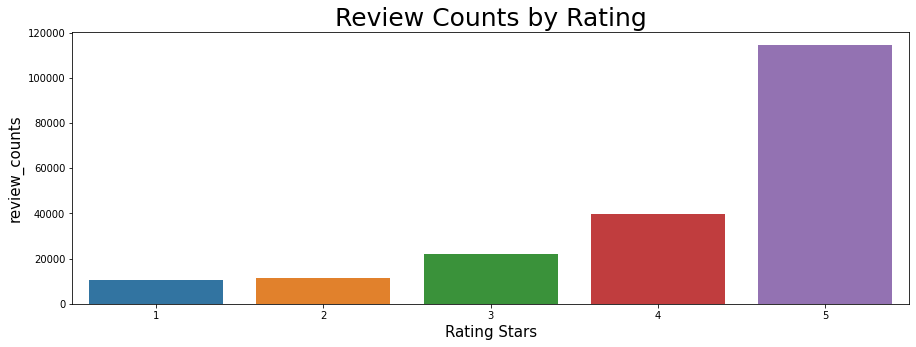

In [ ]:
import seaborn as sns
# plot review counts in different rating group
rating=pd.DataFrame(rating_json['overall'].value_counts()).reset_index().sort_values(by='index',ascending=True)
plt.figure(figsize=(15,5))
sns.barplot(rating['index'],rating['overall'])
plt.xticks(fontsize=10)
plt.xlabel('Rating Stars',fontsize=15)
plt.ylabel('review_counts',fontsize=15)
plt.title('Review Counts by Rating',fontsize=25)
# for i in range(len(rating['index'])):
#     plt.text(i+0.9,list(rating['overall'])[::-1][i]+1000,'{}%'.format(round(rating['overall'][i]/sum(rating['overall'])*100,2)),fontsize=15)
# plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Review Counts by Bad/Good Reviews')

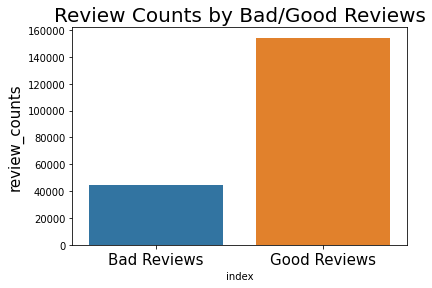

In [ ]:

# plot review counts in bad review group and good review group
bad_good=pd.DataFrame(rating_json['target'].value_counts()).reset_index().sort_values(by='index',ascending=False)

sns.barplot(bad_good['index'],bad_good['target'])
plt.xticks([0,1],["Bad Reviews","Good Reviews"],fontsize=15)
plt.ylabel('review_counts',fontsize=15)
plt.title('Review Counts by Bad/Good Reviews',fontsize=20)

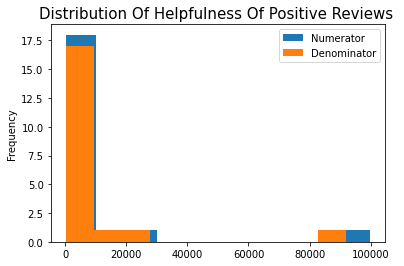

In [ ]:

# distribution of helpfulness_Numerator and helpfulness_Denominator in positive reviews
plt.title('distribution of helpfulness of positive Reviews '.title(),fontsize=15)
rating_json[rating_json['target']==1]['helpfulness_Numerator'].value_counts()[:20].plot(kind='hist',label='Numerator')
rating_json[rating_json['target']==1]['helpfulness_Denominator'].value_counts()[:20].plot(kind='hist',label='Denominator')
plt.legend()
plt.show()

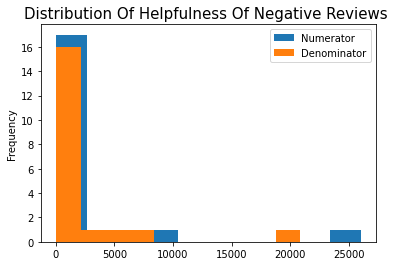

In [ ]:
# distribution of helpfulness_Numerator and helpfulness_Denominator in negative reviews
plt.title('distribution of helpfulness of Negative Reviews '.title(),fontsize=15)
rating_json[rating_json['target']==0]['helpfulness_Numerator'].value_counts()[:20].plot(kind='hist',label='Numerator')
rating_json[rating_json['target']==0]['helpfulness_Denominator'].value_counts()[:20].plot(kind='hist',label='Denominator')
plt.legend()
plt.show()

In [ ]:
rating_json.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,target,helpfulness_Numerator,helpfulness_Denominator
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014",0,3,4
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014",0,1,1


In [ ]:
dfNew = rating_json[['asin','reviewText','overall',"summary"]]

In [ ]:
dfNew

,asin,reviewText,overall,summary
0,7806397051,Very oily and creamy. Not at all what I expect...,1,Don't waste your money
1,7806397051,This palette was a decent price and I was look...,3,OK Palette!
2,7806397051,The texture of this concealer pallet is fantas...,4,great quality
3,7806397051,I really can't tell what exactly this thing is...,2,Do not work on my face
4,7806397051,"It was a little smaller than I expected, but t...",3,It's okay.
...,...,...,...,...
198497,B00LLPT4HI,Just a little dab of this shea butter should b...,5,A little dab...
198498,B00LLPT4HI,This shea butter is completely raw and unrefin...,5,Pure organic raw shea butter
198499,B00LLPT4HI,The skin is the body's largest organ and it ab...,5,One Pound Organic Grade A Unrefined Shea Butter
198500,B00LLPT4HI,I have very dry elbows and knees. I have a to...,5,This stuff is amazing!


In [18]:
count = rating_json.groupby("asin", as_index=False).count()
mean = rating_json.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(rating_json, count, how='right', on=['asin'])
dfMerged

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014",8,8,8,8,8,8,8,8
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014",8,8,8,8,8,8,8,8
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013",8,8,8,8,8,8,8,8
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013",8,8,8,8,8,8,8,8
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013",8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198497,A2BLFCOPSMBOZ9,B00LLPT4HI,Dave Edmiston,"[0, 0]",Just a little dab of this shea butter should b...,5,A little dab...,1405468800,"07 16, 2014",7,7,7,7,7,7,7,7
198498,A1UQBFCERIP7VJ,B00LLPT4HI,Margaret Picky,"[0, 0]",This shea butter is completely raw and unrefin...,5,Pure organic raw shea butter,1405296000,"07 14, 2014",7,7,7,7,7,7,7,7
198499,A35Q0RBM3YNQNF,B00LLPT4HI,M. Hill,"[0, 0]",The skin is the body's largest organ and it ab...,5,One Pound Organic Grade A Unrefined Shea Butter,1405468800,"07 16, 2014",7,7,7,7,7,7,7,7
198500,A3LGT6UZL99IW1,B00LLPT4HI,"Richard C. Drew ""Anaal Nathra/Uthe vas Bethod...","[0, 0]",I have very dry elbows and knees. I have a to...,5,This stuff is amazing!,1405382400,"07 15, 2014",7,7,7,7,7,7,7,7


In [19]:
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198502 entries, 0 to 198501
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   reviewerID_x      198502 non-null  object
 1   asin              198502 non-null  object
 2   reviewerName_x    197116 non-null  object
 3   helpful_x         198502 non-null  object
 4   reviewText_x      198502 non-null  object
 5   overall_x         198502 non-null  int64 
 6   summary_x         198502 non-null  object
 7   unixReviewTime_x  198502 non-null  int64 
 8   reviewTime_x      198502 non-null  object
 9   reviewerID_y      198502 non-null  int64 
 10  reviewerName_y    198502 non-null  int64 
 11  helpful_y         198502 non-null  int64 
 12  reviewText_y      198502 non-null  int64 
 13  overall_y         198502 non-null  int64 
 14  summary_y         198502 non-null  int64 
 15  unixReviewTime_y  198502 non-null  int64 
 16  reviewTime_y      198502 non-null  int

In [20]:
#rename column
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]


dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

In [21]:

dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 100]
dfCount

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,totalReviewers,overallScore,summaryReview
112506,A3BP5ZF51CHZOE,B004OHQR1Q,Caitlyn Johnson,"[7, 9]",first off.... i ordered these expecting there ...,1,crap!,1382572800,"10 24, 2013",431,431,431,431,431,431,431,431,431,1,crap!
112578,A3796JLADKK5Z7,B004OHQR1Q,Freckvanilla,"[0, 0]",I use this all the time helps out with my desi...,5,YOU NEED THIS!!,1372118400,"06 25, 2013",431,431,431,431,431,431,431,431,431,5,YOU NEED THIS!!
112580,A22NETHJ4KTWJP,B004OHQR1Q,gadgetGirl,"[0, 0]",Love the array of colors and the different siz...,5,Great product at a very affordable price,1367798400,"05 6, 2013",431,431,431,431,431,431,431,431,431,5,Great product at a very affordable price
112581,A1L9ZTGO75717E,B004OHQR1Q,gatorsgate,"[0, 0]",I would recommend these dotting tools to anyon...,5,Dotting 5 X 2 Way Marbleizing Dotting Pen Set,1398124800,"04 22, 2014",431,431,431,431,431,431,431,431,431,5,Dotting 5 X 2 Way Marbleizing Dotting Pen Set
112582,A3DDZQYUAE9WNP,B004OHQR1Q,gee,"[0, 0]",These are easy to use. Gets the job done and c...,5,Love the look.,1375833600,"08 7, 2013",431,431,431,431,431,431,431,431,431,5,Love the look.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139486,A33BT7ET6RNHES,B006RFZ66K,Ravelwriter,"[3, 3]",I tend to have an issue with blackheads around...,5,A guilty pleasure,1369872000,"05 30, 2013",100,100,100,100,100,100,100,100,100,5,A guilty pleasure
139487,A2L0WJMOT484GM,B006RFZ66K,reviewer,"[3, 4]",I am a longterm follower of Biore pore strips....,4,blackheads remover,1361577600,"02 23, 2013",100,100,100,100,100,100,100,100,100,4,blackheads remover
139488,A34DC8D55KDAAX,B006RFZ66K,Robbyn.,"[0, 0]","I usually just use the ones for my nose, But i...",4,Pore strips.,1371340800,"06 16, 2013",100,100,100,100,100,100,100,100,100,4,Pore strips.
139489,A2NOW4U7W3F7RI,B006RFZ66K,rpv,"[0, 0]",Biore deep cleansing strips are very effective...,5,24 count is good!,1391126400,"01 31, 2014",100,100,100,100,100,100,100,100,100,5,24 count is good!


In [22]:
dfProductReview = rating_json.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [23]:
dfProductReview

,asin,overall,unixReviewTime
0,7806397051,2.625000,1.382087e+09
1,9759091062,3.090909,1.390930e+09
2,9788072216,5.000000,1.342552e+09
3,9790790961,4.333333,1.378858e+09
4,9790794231,3.600000,1.298212e+09
...,...,...,...
12096,B00L5KTZ0K,5.000000,1.405014e+09
12097,B00L6Q3BH6,4.400000,1.400734e+09
12098,B00LCEROA2,5.000000,1.404643e+09
12099,B00LG63DOM,4.800000,1.405823e+09


In [24]:
# Selecting products with more than 40 reviews
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 40]
dfCount

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,totalReviewers,overallScore,summaryReview
112506,A3BP5ZF51CHZOE,B004OHQR1Q,Caitlyn Johnson,"[7, 9]",first off.... i ordered these expecting there ...,1,crap!,1382572800,"10 24, 2013",431,431,431,431,431,431,431,431,431,1,crap!
112637,A3T5NA2NUA6SH8,B004OHQR1Q,Juana Taveras,"[0, 0]",I'm sure I'm gonna get the best of this dots b...,5,Like it,1372723200,"07 2, 2013",431,431,431,431,431,431,431,431,431,5,Like it
112650,A1ZBG67FX95ZSE,B004OHQR1Q,Kathleen Deffenbaugh,"[0, 0]","These are really great, and well worth the mon...",5,Awesome!,1368057600,"05 9, 2013",431,431,431,431,431,431,431,431,431,5,Awesome!
112627,A1XZ4QLPZXPGV6,B004OHQR1Q,Jessica,"[0, 0]",I havent tried using these but I don't see how...,4,Cant wait,1377475200,"08 26, 2013",431,431,431,431,431,431,431,431,431,4,Cant wait
112628,A11Y1NMAMM89HA,B004OHQR1Q,Jessica Kessler,"[0, 0]",This is such a great deal!! I was looking at t...,4,Dotting Pen Set,1379289600,"09 16, 2013",431,431,431,431,431,431,431,431,431,4,Dotting Pen Set
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28564,AW2YH1Q4CLB6V,B000P6BRHY,"Delaine Godin ""SpiceyD""","[1, 1]","Great pencil and gel for African American, nat...",5,Staple!,1395878400,"03 27, 2014",40,40,40,40,40,40,40,40,40,5,Staple!
40250,A3HOJNJDBR2ML6,B001183N8G,Diamonds In The Sky,"[0, 0]",The best self tanner. I used this in the past ...,5,The best!! Smell could be better though.,1393027200,"02 22, 2014",40,40,40,40,40,40,40,40,40,5,The best!! Smell could be better though.
3683,A1XYGS9BACL5XM,B00008ZPG9,Judy,"[5, 7]",I love the Olay Regenerist line! Moisturizes y...,5,Highly Recommend!,1177200000,"04 22, 2007",40,40,40,40,40,40,40,40,40,5,Highly Recommend!
12017,A1780V0MBZXNRR,B000980PGM,T Brown,"[0, 0]",This is a DAILY and GENTLE exfoliant. Sprinkl...,5,best treat for clear and radiant skin,1326067200,"01 9, 2012",40,40,40,40,40,40,40,40,40,5,best treat for clear and radiant skin


In [25]:
dfProductReview.rename(columns={"asin":"asin"},inplace=True)

df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

df3 = df3[['asin','summaryReview','overall']]
df3

,asin,summaryReview,overall
0,B0000530ED,"['Great Color', 'This Is *Deep-Burgundy-Plum* ...",4.009709
1,B0000632EN,"['Nice small size', 'This product is really ni...",3.802721
2,B0000CC64W,"['Love it', 'Light', 'A skin must-have', 'Noti...",4.314685
3,B000142C1A,"['Beautiful!', 'Pretty - more orange in person...",4.482456
4,B000142FVW,"['my perfect ""Every-day"" soft neutral', ""Looks...",4.552980
...,...,...,...
169,B00KAL5JAU,['Love this in addition to the Dead Sea Mud Sh...,4.761194
170,B00KCFAZTE,"['GREAT FOR PUFFY EYES AND DARK CIRCLES !', 'L...",4.759259
171,B00KHGIK54,"['Preventative Measure!', 'Beautiful Results; ...",4.832061
172,B00KHH2VOY,"['Great Soap', 'LOVE this soap!!', 'another fa...",4.877049


In [26]:
import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()
reviews = df3["summaryClean"] 



In [28]:
from pandas import DataFrame 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [29]:
from pandas import DataFrame 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [30]:
# Train Test split
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [31]:
from sklearn.neighbors import NearestNeighbors
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00AO4EMKQ  average rating is  4.285714285714286
The first similar product is  B005TI7LHS  average rating is  4.139130434782609
The second similar product is  B00AO4EL34  average rating is  4.1909090909090905
-----------------------------------------------------------
Based on product reviews, for  B00AWLB9G6  average rating is  4.39622641509434
The first similar product is  B00AO4E9MC  average rating is  4.339130434782609
The second similar product is  B00AE078YM  average rating is  3.78
-----------------------------------------------------------
Based on product reviews, for  B00AWLB9I4  average rating is  4.207920792079208
The first similar product is  B00AO4E9MC  average rating is  4.339130434782609
The second similar product is  B00AE078YM  average rating is  3.78
-----------------------------------------------------------
Based on product reviews, for  B00C7DYBX0  average rating is  4.098039215686274
The first similar product is  B0090UJFYI  average

In [32]:

df4_train_target = df3["overall"][:lentrain]
df4_test_target = df3["overall"][lentrain:lentrain+lentest]
df4_train_target = df4_train_target.astype(int)
df4_test_target = df4_test_target.astype(int)

n_neighbors = 4
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df4_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df4_test_target, knnpreds_test))

NameError: ignored